# Kish Basin statistics

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy.mpl.ticker import LongitudeFormatter
from matplotlib_scalebar.scalebar import ScaleBar

from h2ss import data as rd

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Read data layers

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
ds

<xarray.Dataset>
Dimensions:          (halite: 4, y: 237, x: 218)
Coordinates:
  * y                (y) float64 5.936e+06 5.936e+06 ... 5.889e+06 5.889e+06
  * x                (x) float64 6.966e+05 6.968e+05 ... 7.398e+05 7.4e+05
    spatial_ref      int64 0
  * halite           (halite) <U8 'Fylde' 'Mythop' 'Preesall' 'Rossall'
    crs              int64 0
Data variables:
    BaseDepth        (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    Thickness        (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    TopDepth         (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    TopTWT           (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    TopDepthSeabed   (halite, y, x) float64 nan nan nan nan ... nan nan nan nan
    BaseDepthSeabed  (halite, y, x) float64 nan nan nan nan ... nan nan nan nan

In [5]:
ds.rio.crs

CRS.from_epsg(23029)

In [6]:
ds.rio.resolution()

(200.0, -200.0)

In [7]:
ds.rio.bounds()

(696500.0, 5889100.0, 740100.0, 5936500.0)

In [4]:
def plot_facet_maps(dat_xr, dat_extent, dat_crs):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    for v in dat_xr.data_vars:
        f = dat_xr[v].plot.contourf(
            col="halite",
            robust=True,
            levels=15,
            cmap="jet",
            col_wrap=2,
            subplot_kws={"projection": ccrs.epsg(dat_crs)},
            xlim=(xmin_, xmax_),
            ylim=(ymin_, ymax_),
        )
        # add a basemap
        basemap = cx.providers.CartoDB.PositronNoLabels
        for n, axis in enumerate(f.axs.flat):
            cx.add_basemap(
                axis, crs=dat_crs, source=basemap, attribution=False
            )
            # add attribution for basemap tiles
            if n == 2:
                axis.text(
                    xmin_, ymin_ - 2500, basemap["attribution"], fontsize=8
                )
        f.set_titles("{value}", weight="semibold")
        plt.show()

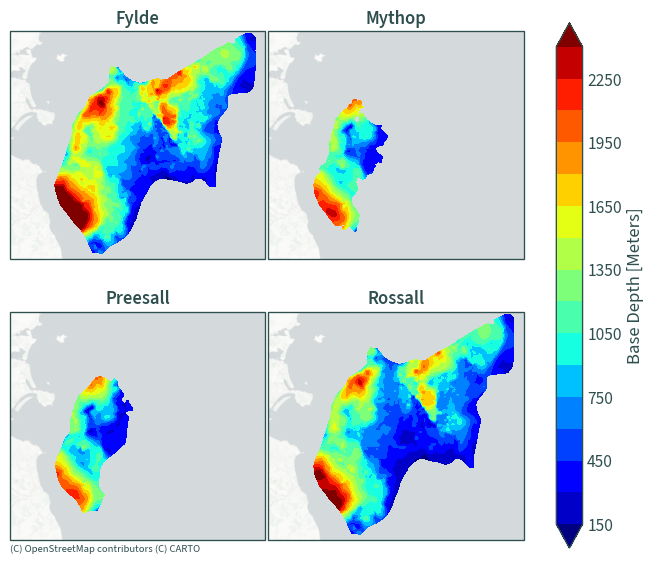

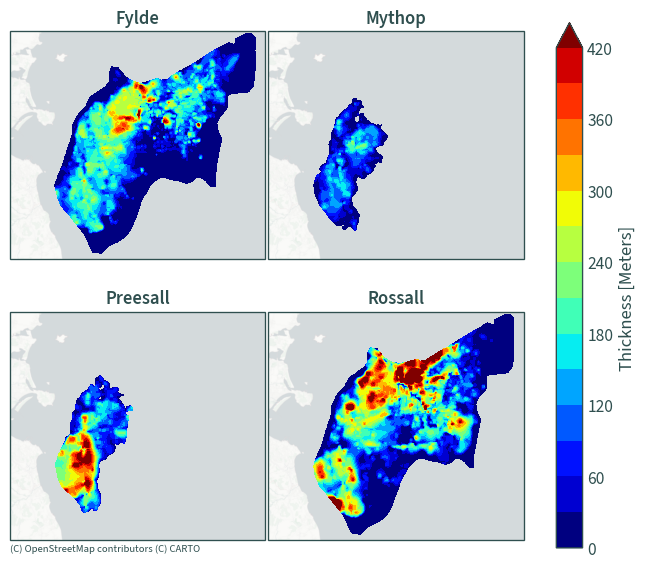

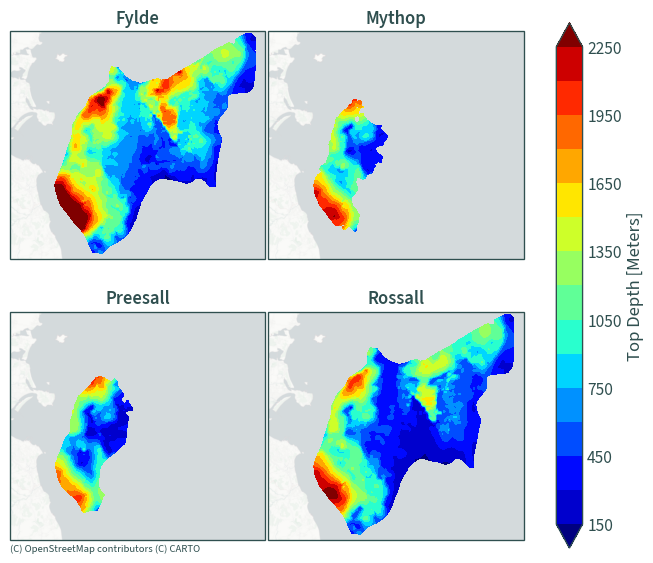

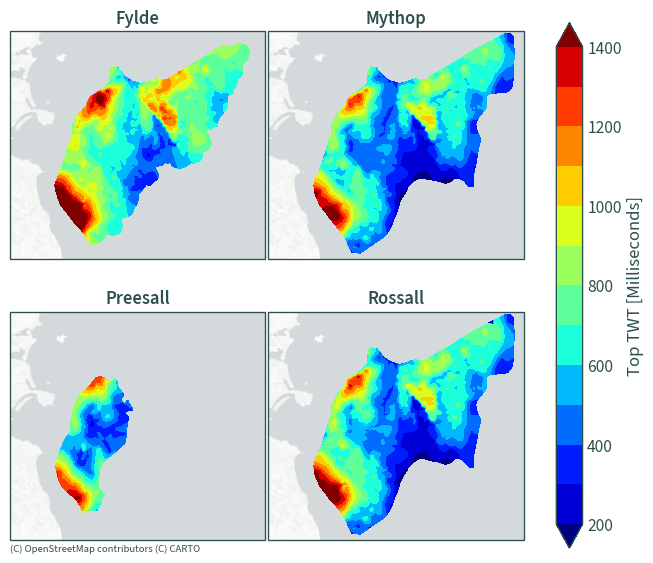

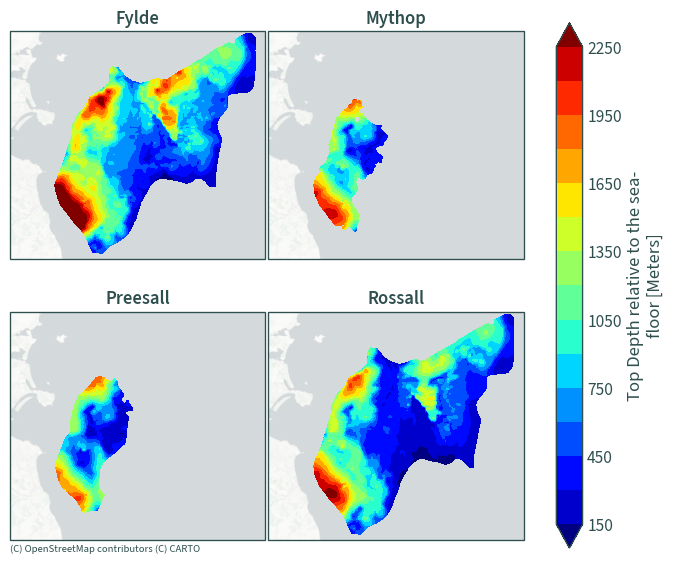

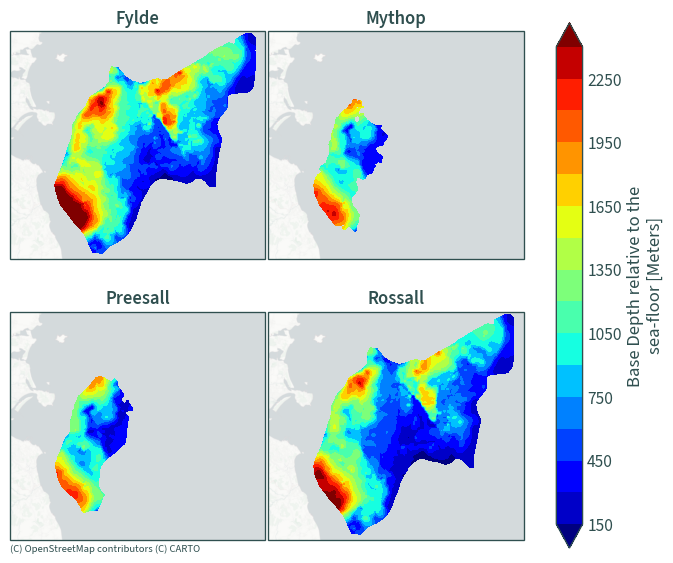

In [9]:
plot_facet_maps(ds, extent, rd.CRS)

## Stats

In [5]:
def make_stats_plots(dat_xr):
    """
    Statistical plots for the halite Xarray dataset

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data

    Returns
    -------
    - The dataset converted into a dataframe
    """

    # convert to dataframe
    dat_df = dat_xr.to_dataframe()[list(dat_xr.data_vars)]

    # pairwise comparison of variables
    sns.pairplot(
        dat_df.reset_index(),
        palette="flare",
        hue="halite",
        plot_kws={"alpha": 0.5},
        vars=["Thickness", "TopDepthSeabed", "BaseDepthSeabed"],
    )
    plt.show()

    # histograms
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    sns.histplot(
        dat_df.reset_index(),
        x="Thickness",
        hue="halite",
        ax=axes[0],
        palette="rocket_r",
        multiple="fill",
        bins=100,
        legend=False,
    )
    sns.histplot(
        dat_df.reset_index(),
        x="TopDepthSeabed",
        hue="halite",
        ax=axes[1],
        palette="rocket_r",
        multiple="fill",
        bins=100,
    )
    plt.tight_layout()
    plt.show()

    # box plots
    fig, axes = plt.subplots(1, 3, figsize=(8, 4.5))
    sns.boxplot(
        dat_df.reset_index(),
        y="Thickness",
        hue="halite",
        palette="flare",
        ax=axes[0],
    )
    sns.boxplot(
        dat_df.reset_index(),
        y="TopDepthSeabed",
        hue="halite",
        palette="flare",
        ax=axes[1],
        legend=False,
    )
    sns.boxplot(
        dat_df.reset_index(),
        y="BaseDepthSeabed",
        hue="halite",
        palette="flare",
        ax=axes[2],
        legend=False,
    )
    plt.tight_layout()
    plt.show()

    return dat_df

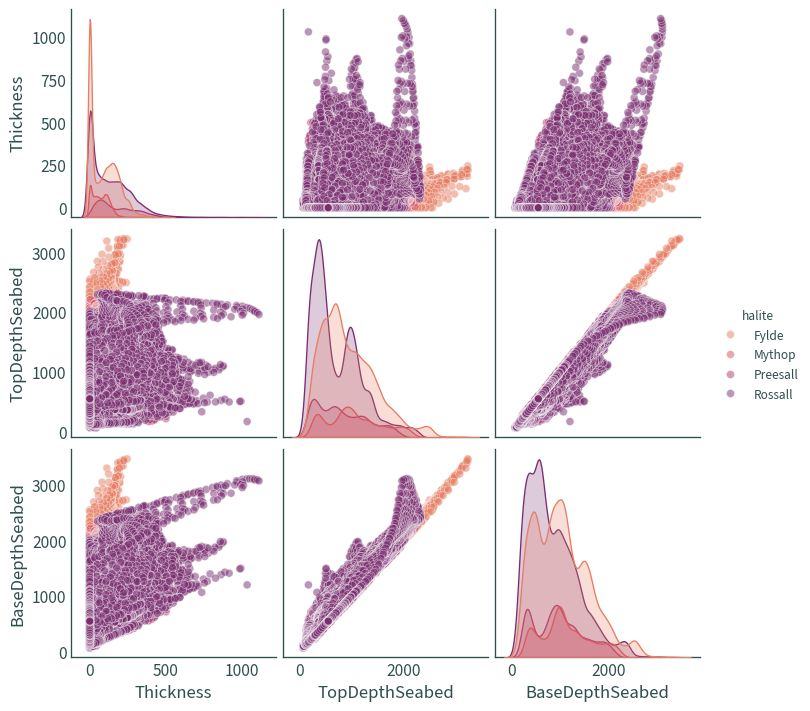

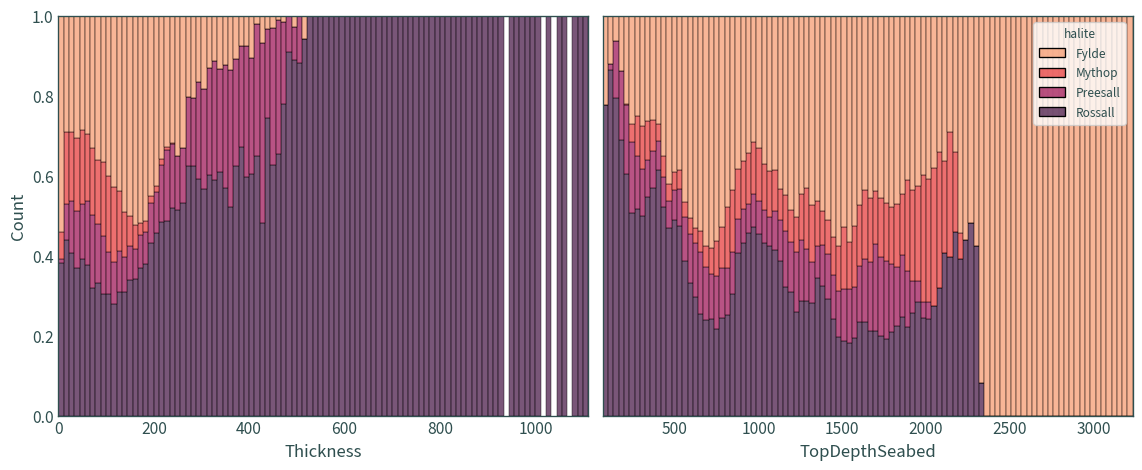

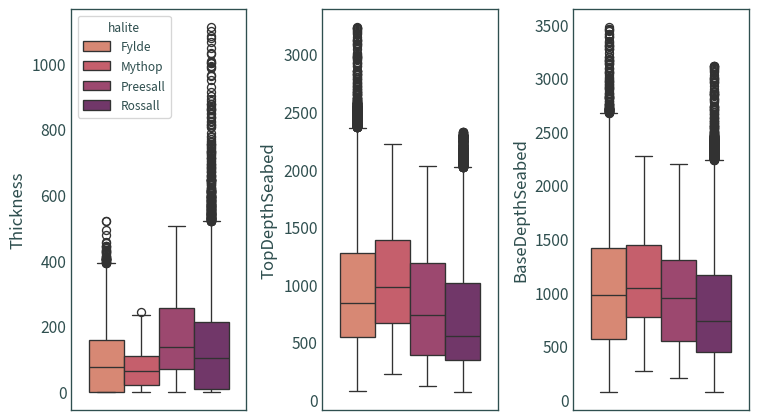

In [11]:
df = make_stats_plots(ds)

In [12]:
df.describe()

,BaseDepth,Thickness,TopDepth,TopTWT,TopDepthSeabed,BaseDepthSeabed
count,63868.000000,63456.000000,63868.000000,80386.000000,63868.000000,63868.000000
mean,1011.301702,112.835875,899.392295,653.242487,852.308746,964.218153
std,536.478279,113.380006,507.401263,259.464713,514.491483,543.935914
min,120.324500,0.000000,120.324500,136.616000,69.237007,73.091809
25%,574.370900,4.344600,476.546675,468.859575,423.502166,517.393110
50%,952.930250,90.634850,818.911100,631.917300,766.899198,906.093512
75%,1334.956375,178.472675,1207.349725,776.623200,1162.222693,1298.014215
max,3512.489700,1111.067000,3273.030800,1911.048300,3234.948776,3475.165874


In [6]:
# surface area
shape = rd.halite_shape(dat_xr=ds)

In [14]:
f"Surface area: {shape.area[0]:.2E} m\N{SUPERSCRIPT TWO}"

'Surface area: 1.02E+09 m²'

In [7]:
def plot_facet_maps_distr(
    dat_xr,
    dat_extent,
    dat_crs,
    v,
    levels,
    label,
    scalebar=True,
    attribution=True,
):
    """
    Helper function to plot facet maps of the halite layers

    Parameters
    ----------
    dat_xr : Xarray dataset of the halite data
    dat_extent : extent of the data
    dat_crs : EPSG CRS
    """

    xmin_, ymin_, xmax_, ymax_ = dat_extent.total_bounds

    f = dat_xr[v].plot.contourf(
        col="halite",
        robust=True,
        levels=levels,
        cmap=sns.color_palette("flare", as_cmap=True),
        figsize=(6, 8.5),
        subplot_kws={"projection": ccrs.epsg(dat_crs)},
        xlim=(xmin_, xmax_),
        ylim=(ymin_, ymax_),
        cbar_kwargs={
            "location": "bottom",
            "aspect": 20,
            "shrink": 0.8,
            "pad": 0.09,
            "extendfrac": 0.2,
            "label": label,
            "format": lambda x, _: f"{x:,.0f}",
        },
        col_wrap=2,
    )

    # add a basemap
    basemap = cx.providers.CartoDB.PositronNoLabels
    for n, axis in enumerate(f.axs.flat):
        cx.add_basemap(axis, crs=dat_crs, source=basemap, attribution=False)
        # tick labels and attribution for basemap tiles
        if n in (0, 2):
            axis.gridlines(draw_labels={"left": "y"}, color="none")
        if n in (2, 3):
            axis.gridlines(
                draw_labels={"bottom": "x"},
                color="none",
                rotate_labels=90,
                xpadding=20,
                xformatter=LongitudeFormatter(number_format=".2f"),
            )
        if n == 3:
            if scalebar:
                axis.add_artist(
                    ScaleBar(
                        1,
                        box_alpha=0,
                        location="lower right",
                        color="darkslategrey",
                        width_fraction=0.015,
                    )
                )
        if n == 2:
            if attribution:
                axis.text(
                    xmin_ + 1000,
                    ymin_ + 1000,
                    basemap["attribution"],
                    fontsize=9,
                )
    f.set_titles("{value}", weight="semibold")
    plt.show()

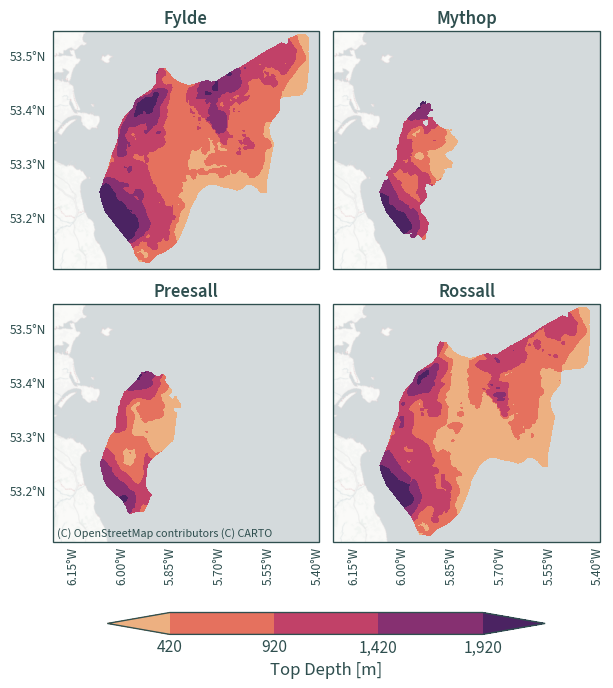

In [8]:
plot_facet_maps_distr(
    ds,
    extent,
    rd.CRS,
    "TopDepthSeabed",
    [500 - 80, 1000 - 80, 1500 - 80, 2000 - 80],
    "Top Depth [m]",
    scalebar=False,
)

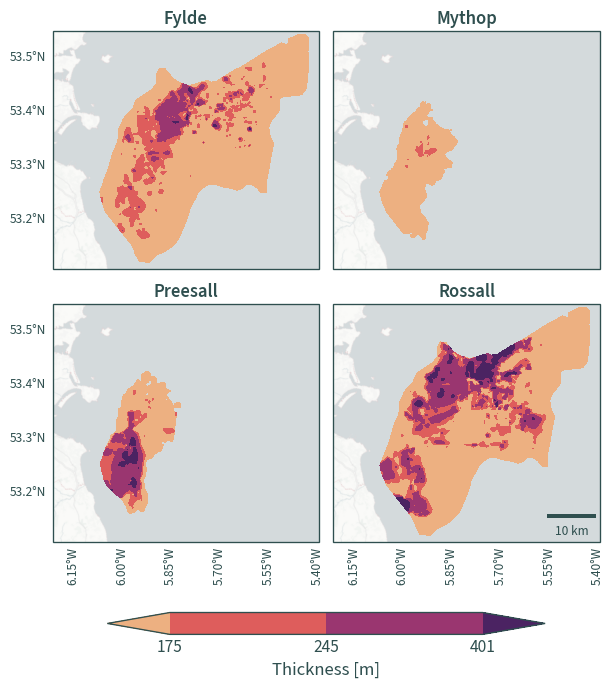

In [9]:
plot_facet_maps_distr(
    ds,
    extent,
    rd.CRS,
    "Thickness",
    [85 + 90, 155 + 90, 311 + 90],
    "Thickness [m]",
    attribution=False,
)

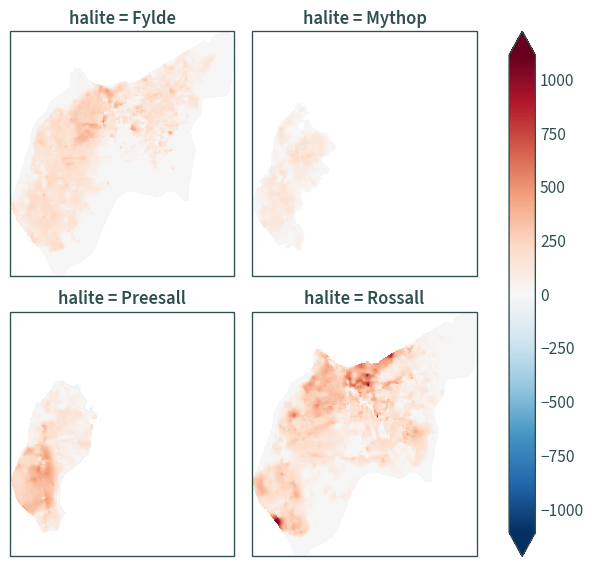

In [20]:
# compare depths
(ds["BaseDepth"] - ds["TopDepth"]).plot(
    col="halite",
    col_wrap=2,
    extend="both",
    subplot_kws={"projection": ccrs.epsg(rd.CRS)},
)
plt.show()

In [18]:
min(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

-53.5

In [19]:
max(set((ds["BaseDepth"] - ds["TopDepth"]).values.flatten()))

1111.0679